In [1]:
from models.gan_model import *
import torch
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import TUDataset
from torch.utils.data import TensorDataset, DataLoader
import networkx as nx

In [2]:
root = './enzymes'
name = 'ENZYMES'

# The ENZYMES dataset
pyg_dataset = TUDataset(root, name)

# You will find that there are 600 graphs in this dataset
print(pyg_dataset)

ENZYMES(600)


In [3]:
def fix_size(graph):
    input_tensor = to_dense_adj(graph.edge_index)
    if input_tensor.shape[1] != 42:
        zeros = torch.zeros(1, input_tensor.shape[1], 42 - input_tensor.shape[1])
        tensor = torch.cat([input_tensor, zeros], dim=2)

        zeros = torch.zeros(1, 42 - input_tensor.shape[1], 42)
        tensor = torch.cat([tensor, zeros], dim=1)
        return tensor
    else:
        return input_tensor

In [4]:
graphs_relevance = [g for g in pyg_dataset if g.num_nodes in [38, 40, 42]]
graphs = torch.zeros(71, 1, 42, 42)
for i in range(len(graphs_relevance)):
    graphs[i] = fix_size(graphs_relevance[i])

In [5]:
batch_size = 8
graphs_dataset = TensorDataset(graphs)
graphs_dataloader = DataLoader(graphs_dataset, batch_size)

In [6]:
lr = 0.001
beta1 = 0.9
beta2 = 0.999

In [7]:
gan = GraphGAN(num_vertex=42)

In [8]:
def train(model, dataloader, num_epochs=10, print_every=1):
    for epoch in range(num_epochs):
        g_l = 0
        d_l = 0
        for batch in dataloader:
            data = batch[0]
            image_size = data.size(0)

            gl, dl = model.forward(data, image_size)
            g_l += gl
            d_l += dl
        if epoch % print_every == 0:
            print("Epoch: " + str(epoch + 1) + "/" + str(num_epochs)
                  + "\td_loss:" + str(round(d_l / len(dataloader), 4))
                  + "\tg_loss:" + str(round(g_l / len(dataloader), 4))
                  )

In [9]:
train(gan, graphs_dataloader, num_epochs=30)

Epoch: 1/30	d_loss:1.0117	g_loss:2.8264
Epoch: 2/30	d_loss:0.9145	g_loss:2.2652
Epoch: 3/30	d_loss:0.6922	g_loss:2.0328
Epoch: 4/30	d_loss:0.5786	g_loss:2.1327
Epoch: 5/30	d_loss:0.3671	g_loss:2.806
Epoch: 6/30	d_loss:0.2817	g_loss:3.3693
Epoch: 7/30	d_loss:0.0985	g_loss:4.278
Epoch: 8/30	d_loss:0.1214	g_loss:5.4093
Epoch: 9/30	d_loss:0.2722	g_loss:6.9957
Epoch: 10/30	d_loss:0.3021	g_loss:9.6709
Epoch: 11/30	d_loss:0.1941	g_loss:12.9066
Epoch: 12/30	d_loss:0.0205	g_loss:14.4145
Epoch: 13/30	d_loss:0.0137	g_loss:12.9482
Epoch: 14/30	d_loss:0.0082	g_loss:14.0976
Epoch: 15/30	d_loss:0.0115	g_loss:13.0146
Epoch: 16/30	d_loss:0.0163	g_loss:13.9026
Epoch: 17/30	d_loss:0.0166	g_loss:13.3703
Epoch: 18/30	d_loss:0.0159	g_loss:13.3868
Epoch: 19/30	d_loss:0.014	g_loss:13.3203
Epoch: 20/30	d_loss:0.0125	g_loss:12.8103
Epoch: 21/30	d_loss:0.0146	g_loss:11.4628
Epoch: 22/30	d_loss:0.0141	g_loss:11.9497
Epoch: 23/30	d_loss:0.0155	g_loss:11.2005
Epoch: 24/30	d_loss:0.0119	g_loss:11.2727
Epoch: 25/30	d

In [10]:
res = gan.generate().squeeze().detach().numpy()

In [11]:
G = nx.from_numpy_array(res, create_using=nx.MultiDiGraph())

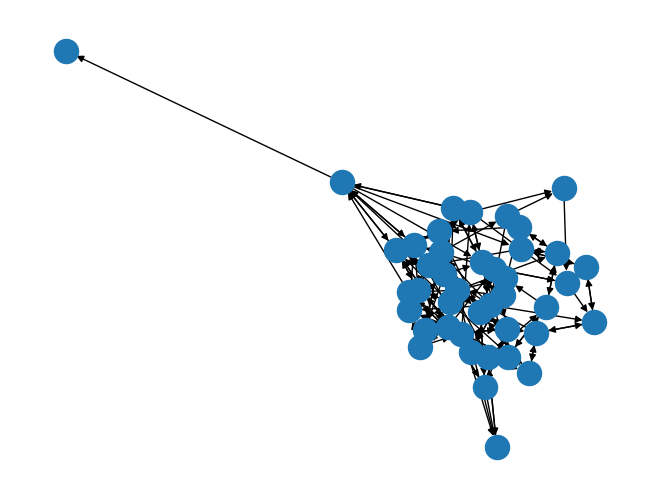

In [12]:
nx.draw(G)